### This assignment may be worked individually or in pairs.

### Enter your name/names here:


In [1]:
# Peter Ma, Nathan Whyte


In [2]:
# headers
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [3]:
# function to calculate adjusted r2
def get_adj_r2(r2, n, p):
    return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

# Assignment 2: Regression and KNN classifier


## Part 1: Regression with scikit-learn

In this part of the assignment, you will fit a regression model to an insurance dataset using the scikit-learn package.

The insurance company would like to be able to estimate the annual medical expenditures they will need to pay for any customer, based on the customer's age, sex, BMI, # of children, whether they are a smoker, and their region of residence.

Estimates from this model can be used to then determine how much to charge each customer for insurance (the more we think you'll cost us, the more we will charge you).


**Data Prep**

Q1. Read the dataset from 'medical-charges.txt' into a Pandas Dataframe. Display the head of the dataset. There should be 1138 rows and 7 columns. The target column (y) is the `charges` column.


In [4]:
med_data = pd.read_csv("medical-charges.txt")

med_data.head()


age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Q2. Notice that there are several categorical columns. You'll need to transform these to be able to do regression. Since `sex` and `smoker` are binary in this dataset, let's do them differently than `region` which has 4 options.

- Use the Pandas [get_dummies()](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) function to one-hot-encode `sex` and `smoker`.
- Since these features are binary, we do not need to create two columns for each of them (i.e. we do not need both smoker_yes and smoker_no - just having a smoker_yes column will be sufficient), so use the `drop_first` parameter of get_dummies to create only a `smoker_yes` and a `sex_male` column.
- Display the head of the dataframe.


In [5]:
med_data = pd.get_dummies(med_data, columns=["sex", "smoker"], drop_first=True)

med_data.head()


age     bmi  children     region      charges  sex_male  smoker_yes
0   19  27.900         0  southwest  16884.92400         0           1
1   18  33.770         1  southeast   1725.55230         1           0
2   28  33.000         3  southeast   4449.46200         1           0
3   33  22.705         0  northwest  21984.47061         1           0
4   32  28.880         0  northwest   3866.85520         1           0

Q3. Now one-hot encode the `region` feature by again using `get_dummies()`, but this time, even though we could drop one column, let's go ahead and explicitly keep all 4 values as columns (i.e. drop_first should be set to False). Display the head of the resulting dataframe.


In [6]:
med_data = pd.get_dummies(med_data, columns=["region"])

med_data.head()


age     bmi  children      charges  sex_male  smoker_yes  region_northeast  \
0   19  27.900         0  16884.92400         0           1                 0   
1   18  33.770         1   1725.55230         1           0                 0   
2   28  33.000         3   4449.46200         1           0                 0   
3   33  22.705         0  21984.47061         1           0                 0   
4   32  28.880         0   3866.85520         1           0                 0   

   region_northwest  region_southeast  region_southwest  
0                 0                 0                 1  
1                 0                 1                 0  
2                 0                 1                 0  
3                 1                 0                 0  
4                 1                 0                 0

Q4. An interesting thing to check with regression problems is whether any of the individual features correlate very strongly with the label. Use the `corr()` method on the dataframe to take a look at this.

Answer as a comment: Do you see any features with a strong correlation to the label?


In [7]:
med_data.corr(method="pearson")

# smokers have high correlation with charges

age       bmi  children   charges  sex_male  \
age               1.000000  0.109272  0.042469  0.299008 -0.020856   
bmi               0.109272  1.000000  0.012759  0.198341  0.046371   
children          0.042469  0.012759  1.000000  0.067998  0.017163   
charges           0.299008  0.198341  0.067998  1.000000  0.057292   
sex_male         -0.020856  0.046371  0.017163  0.057292  1.000000   
smoker_yes       -0.025019  0.003750  0.007673  0.787251  0.076185   
region_northeast  0.002475 -0.138156 -0.022808  0.006349 -0.002425   
region_northwest -0.000407 -0.135996  0.024806 -0.039905 -0.011156   
region_southeast -0.011642  0.270025 -0.023066  0.073982  0.017117   
region_southwest  0.010016 -0.006205  0.021914 -0.043210 -0.004184   

                  smoker_yes  region_northeast  region_northwest  \
age                -0.025019          0.002475         -0.000407   
bmi                 0.003750         -0.138156         -0.135996   
children            0.007673         -0.022808          0.024806   
charges             0.787251          0.006349         -0.039905   
sex_male            0.076185         -0.002425         -0.011156   
smoker_yes          1.000000          0.002811         -0.036945   
region_northeast    0.002811          1.000000         -0.320177   
region_northwest   -0.036945         -0.320177          1.000000   
region_southeast    0.068498         -0.345561         -0.346265   
region_southwest   -0.036945         -0.320177         -0.320829   

                  region_southeast  region_southwest  
age                      -0.011642          0.010016  
bmi                       0.270025         -0.006205  
children                 -0.023066          0.021914  
charges                   0.073982         -0.043210  
sex_male                  0.017117         -0.004184  
smoker_yes                0.068498         -0.036945  
region_northeast         -0.345561         -0.320177  
region_northwest         -0.346265         -0.320829  
region_southeast          1.000000         -0.346265  
region_southwest         -0.346265          1.000000

Q5. Create a plot to show the difference in charges between the smokers and the non-smokers.


<AxesSubplot:title={'center':'Difference in Charges: Smoker vs Non-Smoker'}, ylabel='smoker_yes'>

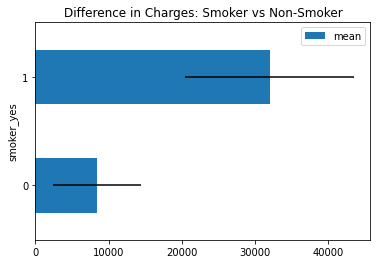

In [8]:
smokers = med_data.groupby("smoker_yes").agg([np.mean, np.std])

smokers = smokers["charges"]
smokers.plot(
    kind="barh",
    y="mean",
    xerr="std",
    title="Difference in Charges: Smoker vs Non-Smoker",
)

Q6. Let's explore the relationship between `age` and `charges`. Create a scatter plot of all data points to show age vs charges.

Answer as a comment: What do you notice about the nature of this relationship?


<AxesSubplot:xlabel='age', ylabel='Charge Amount ($)'>

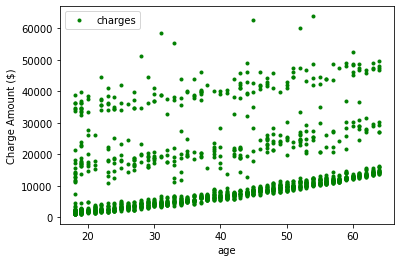

In [9]:
med_data.plot(x="age", y="charges", style=".", c="g", ylabel="Charge Amount ($)")

# There is a slightly positive correlation between age and medical charges.

#### Simple Linear Regression

**Fit a simple linear regression model to predict `charges` from `age`.**

Q7.

- Grab the `age` column from the dataframe and call it something like `x`.
- Grab the `charges` column from the dataframe and call it something like `y`.
- When doing simple linear regression (one feature), you need to convert the features from a Series to a list of lists. You can do this by doing `x = x.values.reshape(-1,1)`, where the (-1,1) means (all rows, one column).
- Do the same to the labels (`y = y.values.reshape(-1,1)`).
- Verify that you have a list of lists for both x and y.


In [10]:
x = med_data.loc[:, "age"]
y = med_data.loc[:, "charges"]

x = x.values.reshape(-1, 1)
y = y.values.reshape(-1, 1)

print(x, "\n")
print(y)

[[19]
 [18]
 [28]
 ...
 [18]
 [21]
 [61]] 

[[16884.924 ]
 [ 1725.5523]
 [ 4449.462 ]
 ...
 [ 1629.8335]
 [ 2007.945 ]
 [29141.3603]]


**Using the holdout method**

Q8. Use [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split your dataset into training and test sets. Do an 80%-20% split. Display how many records are in the training set and how many are in the test set. Set the random_state argument to your favorite number.


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    x, y, test_size=0.20, random_state=1111111111
)

print(len(X_train), len(X_test), len(Y_train), len(Y_test))

1070 268 1070 268


Q9.

- Create a [sklearn.linear_model.LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object.
- Call `fit` on it and pass in the training set.
- Print the slope and the intercept of the equation with the `.coef_` and `.intercept_` attributes.


In [12]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, Y_train)

print("slope:", reg.coef_)
print("inercept:", reg.intercept_)


slope: [[266.03233943]]
inercept: [2777.82587571]


Q10. Now that you've fit the model on the training set, you can evaluate it on the test set. Call `predict` on the linear regression object and pass in the test set. Save the return value - these are all of the predicted values under the model for the test set.

Compute some metrics to see how well this model fits the test data. Use `sklearn.metrics` to print out the MAE, MSE, RMSE, and R2 for the test set under this model. Remember that you have the actual y values for your test set, up in Q8.


In [13]:
import sklearn.metrics as metrics

Y_pred = reg.predict(X_test)

print(metrics.mean_absolute_error(Y_test, Y_pred))
print(metrics.mean_squared_error(Y_test, Y_pred))
print(metrics.mean_squared_error(Y_test, Y_pred, squared=False))
print(metrics.r2_score(Y_test, Y_pred))

9111.976530014059
137696017.3963177
11734.394632716154
0.06115231857764425


Q11. Let's see what the best fit line looks like with the test data. Scatter-plot the test data (x_test, y_test). Then line-plot the model predictions for the test data (x_test, y_test_preds).


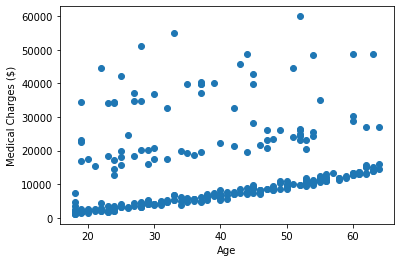

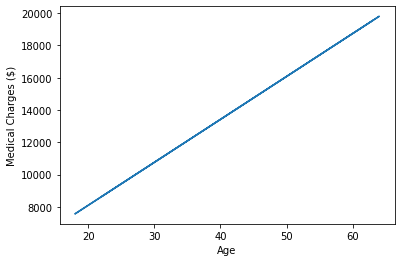

In [14]:
plt.scatter(X_test, Y_test)
plt.xlabel("Age")
plt.ylabel("Medical Charges ($)")
plt.show()

plt.plot(X_test, Y_pred)
plt.xlabel("Age")
plt.ylabel("Medical Charges ($)")
plt.show()


Q12. Now, go back up to your Q8, change the random_state to a different number, and re-run Q9, Q10, Q11.

Answer as a comment: What happened and why?


In [15]:
# The graphs did not change much because if the data is consistent,
#   then the random state of the split should not affect the results.


**Using cross-validation**

Q13. Use `sklearn.model_selection.cross_val_score` to perform 5-fold cross validation on a simple linear regression model.

You will pass the FULL dataset (x and y from before the train/test split in Q8) into `cross_val_score` which will automatically divide it into the number of folds you tell it to, fit a linear regression model to the training set for each fold, and test it on the test set for each fold. It will return a numpy array with the R2 on the test set for each fold. Average these R2 scores to print out the generalization estimate of the model.

On average, after 5 trials with 5 different test sets, this is how well we think a linear regression of using `age` to predict `charges` will work.


In [16]:
from sklearn.model_selection import cross_val_score
from sklearn import linear_model

lasso = linear_model.Lasso()
r2s = np.array(cross_val_score(lasso, x, y))
avg_r2 = np.sum(r2s) / len(r2s)
print("average R2:", avg_r2)

average R2: 0.08821242117430231


#### Multiple Linear Regression

**Fit a multiple linear regression model to predict `charges` from `age` and `smoker`.**


Q14. Now let's see if we can get a better model by including another feature.

- From the one-hot-encoded dataframe (the result of Q3), grab both the `age` and `smoker_yes` columns. Call it something like x.
- (No need to call a reshape this time, since it is multi-dimensional data now.)
- You already have the y's.
- Create a new `sklearn.linear_model.LinearRegression` object. (Or you can re-use the one you already have.)
- Pass it all into a `sklearn.model_selection.cross_val_score` with a 5-fold CV.
- Print out the average R2.
- Once we get into **multiple** linear regression, we should not use R2, we should instead use adjusted-R2. Use the provided (at the top of the file) `get_adj_R2()` function to print out the adjusted R2. (Note, this value will be very close to the R2 because our `n` is large and our `p` is small.)

Answer as a comment: What happens when you include `smoker_yes`?


In [17]:
x = med_data[["age", "smoker_yes"]]

X_train, X_test = train_test_split(x, test_size=0.20, random_state=1337)

reg = LinearRegression().fit(X_train, Y_train)

r2s = np.array(cross_val_score(reg, x, y))
avg_r2 = np.sum(r2s) / len(r2s)
print("average R2:", avg_r2)

print("Adjusted R2", get_adj_r2(avg_r2, len(x), 2))

# the accuracy (the result of cross_val_score()) increased dramaitcally when we added 'smoker_yes'


average R2: 0.7191692504028052
Adjusted R2 0.7187485301786896


Q15. Let's go one more step and see if including ALL of our features is even better at predicting the `charges` than using just `age` and `smoker`.

- From the one-hot-encoded dataframe (the result of Q3), grab all the features, but NOT the target. Call it something like x.
- (No need to call a reshape this time, since it is multi-dimensional data now.)
- You already have the y's.
- Create a new sklearn.linear_model.LinearRegression object. (Or you can re-use the one you already have.)
- Pass it all into a sklearn.model_selection.cross_val_score with a 5-fold CV.
- Print out the average R2 and the adjusted R2.


In [18]:
x = med_data.copy()
x = x.drop("charges", axis=1)
x.head()

X_train, X_test = train_test_split(x, test_size=0.20, random_state=1337)

reg = LinearRegression().fit(X_train, Y_train)

r2s = np.array(cross_val_score(reg, x, y))
avg_r2 = np.sum(r2s) / len(r2s)
print("average R2:", avg_r2)

print("Adjusted R2", get_adj_r2(avg_r2, len(x), 9))


average R2: 0.746861624347374
Adjusted R2 0.7451460781268366


Q16. Build the final model on the entire dataset.

- You should already have your x from the previous question (Q15).
- You already have the y's.
- Create a new `sklearn.linear_model.LinearRegression` object, or you can re-use the one you already have.
- Call `fit` and pass in all the data (x, y).
- Print out the coefficients and the intercept of the fitted model. The coefficients correspond to the the order in which the features are in the dataframe (x).

This defines your multiple linear regression equation!


In [19]:
reg = LinearRegression().fit(x, y)
print("Coefficient:", reg.coef_)
print("Intercept:", reg.intercept_)


Coefficient: [[  256.85635254   339.19345361   475.50054515  -131.3143594
  23848.53454191   587.00923503   234.0453356   -448.01281436
   -373.04175627]]
Intercept: [-12525.5478112]


## Part 2: K-Nearest Neighbors from scratch

In this part of the assignment you'll implement the K-Nearest Neighbors (KNN) classification algorithm to classify patients as either having or not having diabetic retinopathy. For this task we'll be using the same Diabetic Retinopathy data set which was used in the previous assignment on decision trees.


You may use the following function to print a confusion matrix:


In [20]:
def print_confusion_matrix(TP, FN, FP, TN):

    table_data = [[TP, FN], [FP, TN]]
    df = pd.DataFrame(table_data, columns=["Predicted 1", "Predicted 0"])
    df = df.rename(index={0: "Actual 1", 1: "Actual 0"})
    display(df)

In [21]:
# you may use these constants if you want
LABEL_COLUMN = 19
BINARY_COLUMNS = {0, 1, 18}

Q1. Normalize the data so that each feature value lies between `[0-1]`.

In class, we talked about why scaling the data is critical to KNN. We also talked about how data scaling should be done _inside the cross validataion loop_. This means that the scaling parameters should be based on the **training set only**, in order to prevent data leakage. Then the test data will need to be scaled, using the parameters found on the **training** data.

Fill in the function to take in a training dataset and a test dataset and normalize them correctly. Return the normalized datasets.

Caution: Return NEW datasets that have been normalized - do not normalize the datasets in-place, so that this can be run numerous times without altering the original data or normalizing already normalized data.

Hint: When using dataframes, you can do this without a loop!


In [22]:
from sklearn import preprocessing


def normalize_data(train, test):
    # train_norm = (train - train.mean()) / train.std()
    # test_norm = (test - test.mean()) / test.std()

    train_values = train.values
    scaler = preprocessing.MinMaxScaler()
    train_scaled = scaler.fit_transform(train_values)
    train_norm = pd.DataFrame(train_scaled)

    test_values = test.values
    scaler = preprocessing.MinMaxScaler()
    test_scaled = scaler.fit_transform(test_values)
    test_norm = pd.DataFrame(test_scaled)

    return train_norm, test_norm


Q2. The distance calculation method is central to the KNN algorithm. In this assignment you'll be using the Euclidean distance.

Implement a function that takes in one data point (as a list), and the training data (as a dataframe), and calculates the Euclidian distance from the single data point to each of the data points in the training data.

You may return these however you want (or may add them to the dataframe?).

Hint:
For KNN, the distance calculations are the most time-consuming part of the algorithm. Even though computing Euclidian distance seems like a simple, and therefore quick, calculation, running it thousands of times, inside of a nested 5-fold cross-validation for example, can cause this algorithm to take a very long time to run, depending on your implementation.

Remember, you almost never need to loop a Dataframe! Pandas DataFrames have been specifically optimized for fast operations on large datasets, by [vectorizing](https://www.quantifisolutions.com/vectorization-part-2-why-and-what) calculations across all rows at once.

If you use a DataFrame, you should not write a loop to calculate each of the Euclidian distances one at a time. Look at [this post](https://stackoverflow.com/questions/46908388/find-euclidean-distance-from-a-point-to-rows-in-pandas-dataframe?rq=1) for more info.

Caution: Be careful not to use the label in your distance calculation.


In [23]:
def get_distances(point: pd.Series, df: pd.DataFrame):

    df_no_label = df.iloc[:, :19]
    point_no_label = point.iloc[:19]

    df["distance"] = np.linalg.norm(
        df_no_label.sub(np.array(point_no_label)), axis=1)

    return df[["distance", LABEL_COLUMN]]


Q3. Build your KNN classifier.

This function takes in a training set (as a dataframe), a test set (as a dataframe), and a k to use, and classifies all data points in the test set, using the data in the training set and the given k.

It should return the predicted labels for the test set as a list.

Caution: Remember to normalize your data before doing distance calculations.


In [24]:
def run_knn(train_set: pd.DataFrame, test_set: pd.DataFrame, k: int) -> np.array:

    train_norm, test_norm = normalize_data(train_set, test_set)

    predictions = []
    for index, row in test_norm.iterrows():
        distance = get_distances(row, train_norm)
        sorted_distance = distance.sort_values(by="distance")

        sorted_distance = sorted_distance[:k]

        class_counts = sorted_distance.groupby(LABEL_COLUMN).size()

        try:
            class_counts.loc[0.0]
        except:
            predictions.append(1)
            continue

        try:
            class_counts.loc[1.0]
        except:
            predictions.append(0)
            continue

        predictions.append(
            0 if class_counts.loc[0.0] > class_counts.loc[1.0] else 1)

    return np.array(predictions)


Q4. Find the best value of k for this data.

Try k ranging from 1 to 10 (odds only). For each k value, use a 5-fold cross validation to evaluate the accuracy with that k. In each fold of CV, divide your data into a training set and a validation set. Print out the best value of k and the accuracy achieved with that value. Return the best value of k. If there is a tie for best k, use the lowest of the k values.

Hint: This is the _inner_ loop of a nested cross validation.


In [25]:
from sklearn.model_selection import KFold


def find_best_k(data):

    best_k = 0
    most_correct = 0.0
    for k in range(1, 11, 2):

        kf = KFold(n_splits=5)
        best_k_splits = kf.get_n_splits(data)

        for training_indices, validation_indices in kf.split(data):
            training_set, validation_set = (
                data[: len(training_indices)],
                data[: len(validation_indices)],
            )

            predictions = run_knn(training_set, validation_set, k)
            num_correct = np.count_nonzero(
                predictions == validation_set.iloc[:, LABEL_COLUMN])

            if num_correct > most_correct:
                most_correct = num_correct
                best_k = k

    return best_k


Q5. Now measure the accuracy of your classifier using 5-fold cross validation.

In each fold of this CV, divide your data into a training set and a test set. The training set should get sent through your code for Q4, resulting in a value of k to use. Using that k, calculate an accuracy on the test set. You will average the accuracy over all 5 folds to obtain the final accuracy measurement.

Print the accuracy, the confusion matrix, and the precision and recall for class label 1 (patients that have been diagnosed with the disease).


In [45]:

import time


def run_CV():
    # read in data
    data = pd.read_csv("messidor_features.txt", header=None)

    start_time = time.time()

    partition_size = len(data) // 5
    accuracy_total = 0.0
    for k in range(0, 5):
        best_k = find_best_k(data)

        p_start = k * partition_size
        p_end = p_start + partition_size

        test_set = data.iloc[p_start:p_end]

        training_set_left = data.iloc[0:p_start]
        training_set_right = data.iloc[p_end:len(data)]
        training_set = pd.concat([training_set_left, training_set_right])
        
        predictions = run_knn(training_set, test_set, best_k)
        num_correct = np.count_nonzero(
            predictions == test_set.iloc[:, LABEL_COLUMN]
        )
        accuracy = num_correct / len(test_set)
        
        
        tp, fp, tn, fn = 0, 0, 0, 0
        test_set = test_set.reset_index()
        for index, row in test_set.iterrows():
            actual_val = row.iloc[LABEL_COLUMN];
            if actual_val == 1:
                # FP 
                if actual_val == predictions[index]: # TP
                    tp+= 1
                else:
                    fp+= 1
                
            else:
                if actual_val == predictions[index]:
                    tn+= 1
                else:
                    fn+= 1
      
        
        
        accuracy_total += accuracy
        
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        
      
        print_confusion_matrix(tp, fn, fp, tn)
        print("Accuracy:", accuracy)
        print("Precision:", prec)
        print("Recall:", rec, "\n--------")
        

    end_time = time.time()
    print("\nTotal time (seconds):", end_time - start_time)

    final_accuracy = accuracy_total / 5
    print("Average accuracy:", final_accuracy)


run_CV()

Predicted 1  Predicted 0
Actual 1           33          107
Actual 0           35           55

Accuracy: 0.6521739130434783
Precision: 0.4852941176470588
Recall: 0.2357142857142857 
--------


Predicted 1  Predicted 0
Actual 1           15           66
Actual 0           58           91

Accuracy: 0.6347826086956522
Precision: 0.2054794520547945
Recall: 0.18518518518518517 
--------


Predicted 1  Predicted 0
Actual 1           34           83
Actual 0           52           61

Accuracy: 0.6652173913043479
Precision: 0.3953488372093023
Recall: 0.2905982905982906 
--------


Predicted 1  Predicted 0
Actual 1           31          107
Actual 0           44           48

Accuracy: 0.6521739130434783
Precision: 0.41333333333333333
Recall: 0.2246376811594203 
--------


Predicted 1  Predicted 0
Actual 1           38           61
Actual 0           47           84

Accuracy: 0.6043478260869565
Precision: 0.4470588235294118
Recall: 0.3838383838383838 
--------

Total time (seconds): 155.96310806274414
Average accuracy: 0.6417391304347826
